In [1]:
import os
import numpy as np
import pandas as pd

**path指定**

In [2]:
base_dir = '/content/drive/MyDrive/kaggle/signLanguage/csv'
train_dir = base_dir + '/train'
test_dir = base_dir + '/test'

#trainのデータ読み込み

In [3]:
# dir内のフォルダ数を数える
folder_count = 0
dir = train_dir
for path in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, path)):
        folder_count += 1
print(folder_count)

20


In [4]:
for i in range(1,folder_count+1):
    exec_command = 'train_sign' + str(i) + "_path = train_dir + '/sign_" + str(i) + "/'"
    exec(exec_command)

In [5]:
train_sign1_path  # パス確認

'/content/drive/MyDrive/kaggle/signLanguage/csv/train/sign_1/'

In [6]:
frame = 60
y=[]
for i in range(1,folder_count+1):
    # sign1-sign20のpathを指定
    path_exec_command = 'path = train_sign' + str(i) + '_path'
    exec(path_exec_command)

    files=os.listdir(path)
    lists=[]  # 同じsignのデータを3次元listに格納する
    for file in files:
        df = pd.read_csv(path+file, index_col=0)

        df = df.iloc[:,1404:]  # 顔の情報を削除468x3
        df = df.iloc[:,63:]  # 左手の情報を削除21x3

        df = df.fillna(0.1)  # 欠損データ

        # フレームの補完．60フレームに足りない場合は最後のフレームで補完     
        if len(df) < frame:
            for f in range(len(df), frame):
                df=df.append(df.tail(1))

        lists.append(df.values[:frame, :].tolist())  # signごとに結合
        y.append(i - 1)# ラベル
        
    csv_exec_command = 'train_sign' + str(i) + '= np.array(lists)'
    exec(csv_exec_command)

In [7]:
print(train_sign1.shape) # 動画数,フレーム数,特徴量

(40, 60, 162)


In [8]:
y=np.array(y)
print(y)
y.shape

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8

(800,)

**trainデータの結合**

In [9]:
X=train_sign1
for i in range(2,folder_count+1):
    exec_command = 'X = np.concatenate([X, train_sign'+ str(i) +'], 0)'
    exec(exec_command)

print(X.shape)

(800, 60, 162)


#trainとvalidを分割する

In [10]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, np_utils.to_categorical(y), test_size=0.1)

In [11]:
train_x.shape[1:]

(60, 162)

#モデルの構成と学習

In [12]:
from keras.layers.advanced_activations import LeakyReLU
from keras import layers
from keras import models
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout,LeakyReLU
from keras import optimizers

model = Sequential()
model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=train_x.shape[1:]))
model.add(Dense(train_y.shape[1], activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                58112     
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 59,412
Trainable params: 59,412
Non-trainable params: 0
_________________________________________________________________


In [13]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
h=model.fit(train_x, 
            train_y, 
            epochs= 300,
            verbose=1, 
            validation_data=(val_x, val_y))

Epoch 1/300
23/23 [==============================] - 11s 312ms/step - loss: 2.9654 - accuracy: 0.0736 - val_loss: 2.8255 - val_accuracy: 0.2000
Epoch 2/300
23/23 [==============================] - 7s 292ms/step - loss: 2.7028 - accuracy: 0.2000 - val_loss: 2.5757 - val_accuracy: 0.3000
Epoch 3/300
23/23 [==============================] - 7s 293ms/step - loss: 2.3652 - accuracy: 0.3347 - val_loss: 2.2559 - val_accuracy: 0.3125
Epoch 4/300
23/23 [==============================] - 7s 297ms/step - loss: 2.2667 - accuracy: 0.2972 - val_loss: 2.2721 - val_accuracy: 0.4000
Epoch 5/300
23/23 [==============================] - 7s 308ms/step - loss: 2.0879 - accuracy: 0.4083 - val_loss: 1.9067 - val_accuracy: 0.5125
Epoch 6/300
23/23 [==============================] - 8s 342ms/step - loss: 1.8570 - accuracy: 0.4514 - val_loss: 1.7745 - val_accuracy: 0.4375
Epoch 7/300
23/23 [==============================] - 7s 325ms/step - loss: 1.7557 - accuracy: 0.4694 - val_loss: 1.6549 - val_accuracy: 0.487

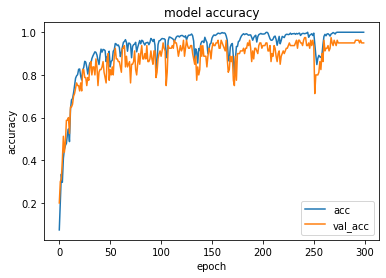

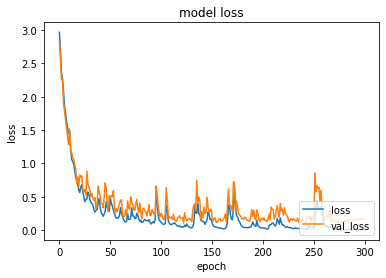

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

plot_history(h)

In [16]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, '../LSTM.hdf5')
model.save(hdf5_file)

#testのデータ読み込み

In [17]:
# dir内のフォルダ数を数える
folder_count = 0
dir = test_dir
for path in os.listdir(dir):
    if os.path.isdir(os.path.join(dir, path)):
        folder_count += 1
print(folder_count)

20


In [18]:
for i in range(1,folder_count+1):
    exec_command = 'test_sign' + str(i) + "_path = test_dir + '/sign_" + str(i) + "/'"
    exec(exec_command)

In [19]:
test_sign1_path  # パス確認

'/content/drive/MyDrive/kaggle/signLanguage/csv/test/sign_1/'

In [20]:
frame = 60
test_y=[]
for i in range(1,folder_count+1):
    # sign1-sign20のpathを指定
    path_exec_command = 'path = test_sign' + str(i) + '_path'
    exec(path_exec_command)

    files=os.listdir(path)
    lists=[]  # 同じsignのデータを3次元listに格納する
    for file in files:
        df = pd.read_csv(path+file, index_col=0)

        df = df.iloc[:,1404:]  # 顔の情報を削除468x3
        df = df.iloc[:,63:]  # 左手の情報を削除21x3

        df = df.fillna(0.1)  # 欠損データ

        # フレームの補完．60フレームに足りない場合は最後のフレームで補完     
        if len(df) < frame:
            for f in range(len(df), frame):
                df=df.append(df.tail(1))

        lists.append(df.values[:frame, :].tolist())  # signごとに結合
        test_y.append(i - 1)# ラベル
    csv_exec_command = 'test_sign' + str(i) + '= np.array(lists)'
    exec(csv_exec_command)

In [21]:
test_x=test_sign1
for i in range(2,folder_count+1):
    exec_command = 'test_x = np.concatenate([test_x, test_sign'+ str(i) +'], 0)'
    exec(exec_command)

#testによるモデル評価

In [23]:
test_score = model.evaluate(test_x, np_utils.to_categorical(test_y))

7/7 [==============================] - 0s 40ms/step - loss: 0.2220 - accuracy: 0.9350


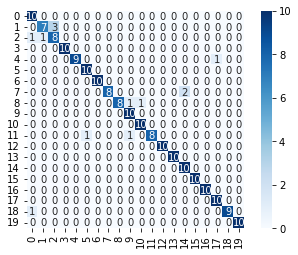

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred = model.predict(test_x)
pred_classes = np.argmax(pred, axis=1)
cm = confusion_matrix(test_y, pred_classes)

sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.savefig('sklearn_confusion_matrix.png')
